### Extract zipfile

In [1]:
import zipfile
import os

# First, let's see what's inside the ZIP file
filename = "arugambay_data_2022_07.nc"

print("Contents of the ZIP file:")
with zipfile.ZipFile(filename, 'r') as zip_file:
    file_list = zip_file.namelist()
    for file in file_list:
        print(f"  - {file}")
    
    # Extract all files to current directory
    print(f"\nExtracting {len(file_list)} files...")
    zip_file.extractall()
    print("✅ Extraction complete!")

# Now find the actual NetCDF file(s)
print("\nLooking for .nc files in current directory:")
for file in os.listdir('.'):
    if file.endswith('.nc'):
        size = os.path.getsize(file)
        print(f"  - {file} ({size:,} bytes)")

Contents of the ZIP file:
  - data_stream-oper_stepType-instant.nc
  - data_stream-oper_stepType-accum.nc
  - data_stream-wave_stepType-instant.nc

Extracting 3 files...
✅ Extraction complete!

Looking for .nc files in current directory:
  - arugambay_data_2022_07.nc (324,000 bytes)
  - data_stream-oper_stepType-accum.nc (52,081 bytes)
  - data_stream-oper_stepType-instant.nc (206,332 bytes)
  - data_stream-wave_stepType-instant.nc (65,070 bytes)


### Load NetCDF

In [2]:
import xarray as xr

# Load and combine all three files
files = [
    "data_stream-oper_stepType-instant.nc",  # u10, v10, msl, sst, tcc
    "data_stream-oper_stepType-accum.nc",   # tp (precipitation)  
    "data_stream-wave_stepType-instant.nc"  # swh (wave height)
]

# Manual merge (more control)
datasets = []
for file in files:
    ds = xr.open_dataset(file)
    datasets.append(ds)
    print(f"Loaded {file}")

# Merge all datasets
combined_ds = xr.merge(datasets, compat='override')
print(f"\nCombined dataset:")
print(f"   Variables: {list(combined_ds.data_vars.keys())}")
print(f"   Dimensions: {dict(combined_ds.dims)}")
print(f"   Time range: {combined_ds.valid_time.min().values} to {combined_ds.valid_time.max().values}")
print(f"   Spatial extent: lat {combined_ds.latitude.min().values}° to {combined_ds.latitude.max().values}°")
print(f"                   lon {combined_ds.longitude.min().values}° to {combined_ds.longitude.max().values}°")

print(f"\nDataset info:")
print(combined_ds)

Loaded data_stream-oper_stepType-instant.nc
Loaded data_stream-oper_stepType-accum.nc
Loaded data_stream-wave_stepType-instant.nc

Combined dataset:
   Variables: ['u10', 'v10', 'msl', 'sst', 'tcc', 'tp', 'swh']
   Dimensions: {'valid_time': 124, 'latitude': 11, 'longitude': 11}
   Time range: 2022-07-01T00:00:00.000000000 to 2022-07-31T18:00:00.000000000
   Spatial extent: lat 5.0° to 10.0°
                   lon 80.0° to 85.0°

Dataset info:
<xarray.Dataset> Size: 423kB
Dimensions:     (valid_time: 124, latitude: 11, longitude: 11)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 992B 2022-07-01 ... 2022-07-31T18...
  * latitude    (latitude) float64 88B 10.0 9.5 9.0 8.5 8.0 ... 6.5 6.0 5.5 5.0
  * longitude   (longitude) float64 88B 80.0 80.5 81.0 81.5 ... 84.0 84.5 85.0
    expver      (valid_time) <U4 2kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 60kB ...
    v10         (valid_time, latitude, longitude) floa

C:\Users\Hasi\AppData\Local\Temp\ipykernel_17816\3065985461.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(combined_ds.dims)}")


### Feat engineering

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
# Single Timeframe
time = "2022-07-15T12:00"
snapshot = combined_ds.sel(valid_time=time)

# Coordinates
lon = snapshot.longitude
lat = snapshot.latitude

#### Wind Speed, Wind Direction and Mean Sea Level Pressure

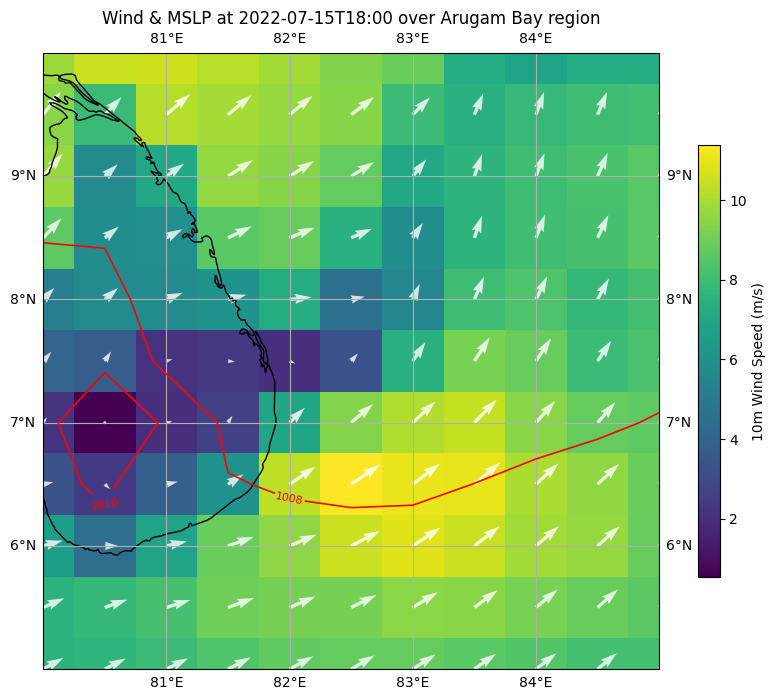

Wind speed range: 0.5 - 11.4 m/s
MSLP range: 1006.1 - 1011.5 hPa


In [15]:
# Wind components
u = snapshot["u10"]  # 10m u-component 
v = snapshot["v10"]  # 10m v-component

# Calculate wind speed using u & v
wind_speed = np.sqrt(u**2 + v**2)

# Mean sea level pressure
mslp = snapshot["msl"]  # Already in Pascals

# Set up projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([80, 85, 5, 10], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.gridlines(draw_labels=True)

# Plot wind speed as color shading
cs = ax.pcolormesh(lon, lat, wind_speed, cmap="viridis", shading="auto", transform=ccrs.PlateCarree())

# Overlay wind vectors (arrows) - subsample for cleaner display
skip = 1  # Use every point, change to 2 or 3 to thin out arrows
ax.quiver(lon[::skip], lat[::skip], u[::skip, ::skip], v[::skip, ::skip], 
         scale=200, transform=ccrs.PlateCarree(), color='white', alpha=0.8)

# Overlay MSLP contours - convert from Pa to hPa
contours = ax.contour(lon, lat, mslp/100, colors="red", linewidths=1.2, 
                     levels=np.arange(1000, 1020, 2), transform=ccrs.PlateCarree())
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# Colorbar
cbar = plt.colorbar(cs, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("10m Wind Speed (m/s)")

plt.title(f"Wind & MSLP at {time} over Arugam Bay region")
plt.show()

# Print some info about the data
print(f"Wind speed range: {wind_speed.min().values:.1f} - {wind_speed.max().values:.1f} m/s")
print(f"MSLP range: {(mslp/100).min().values:.1f} - {(mslp/100).max().values:.1f} hPa")

#### Significant Wave Height

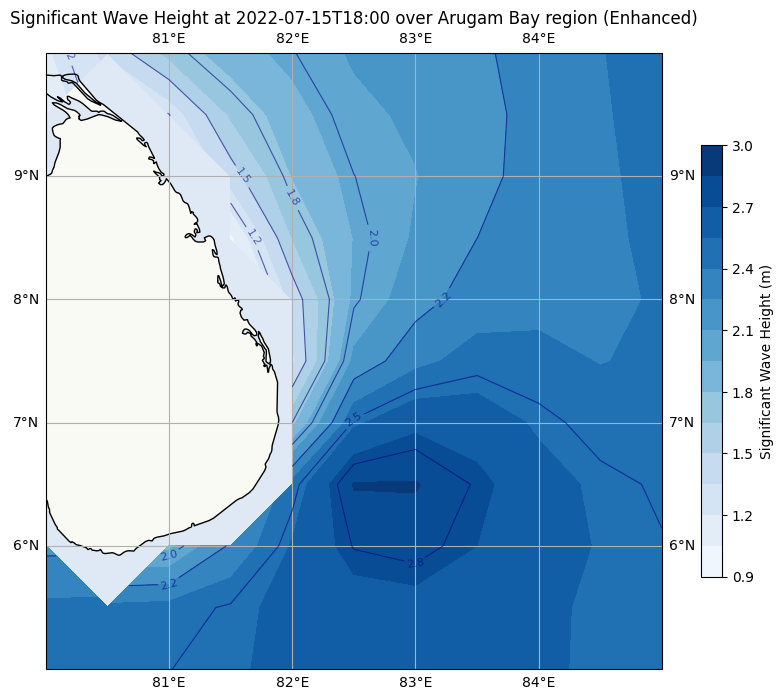

SWH range: 1.02 - 2.86 m
Mean SWH: 2.26 m


In [10]:
# Create an enhanced visualization of significant wave height with contour lines
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([80, 85, 5, 10], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.gridlines(draw_labels=True)

# Plot wave height with filled contours for smoother appearance
cs = ax.contourf(snapshot.longitude, snapshot.latitude, snapshot["swh"], 
                 levels=15, cmap="Blues", transform=ccrs.PlateCarree())

# Add contour lines
contours = ax.contour(snapshot.longitude, snapshot.latitude, snapshot["swh"], 
                     colors="navy", linewidths=0.8, alpha=0.6, 
                     transform=ccrs.PlateCarree())
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Add colorbar
cbar = plt.colorbar(cs, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Significant Wave Height (m)")

plt.title(f"Significant Wave Height at {time} over Arugam Bay region (Enhanced)")
plt.show()

print(f"SWH range: {snapshot['swh'].min().values:.2f} - {snapshot['swh'].max().values:.2f} m")
print(f"Mean SWH: {snapshot['swh'].mean().values:.2f} m")